In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import sys
sys.path.append('../')
# sys.path.append('../')
from utils.load_dataset import TimeSeries
from utils.metrics import covering, f_measure
# from tqdm import tqdm, trange
from tqdm.auto import tqdm
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import torchsde
from itertools import chain
import os
from torch.utils.data import DataLoader
from scripts.models import *
from scripts.data import CPDataset
import json
from utils.init import init_weights
from utils.optim import Ranger
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [5]:
class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self, state_size, hidden_dim, brownian_size=2):
        super().__init__()
        self.state_size = state_size
        self.brownian_size = brownian_size
        self.mu = nn.Sequential(
            nn.Linear(state_size + 1, 
                      hidden_dim),
            nn.LeakyReLU(),
#             nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 
                      hidden_dim),
            nn.LeakyReLU(),
            
#             nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 
                      hidden_dim),
            nn.LeakyReLU(),
#             nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 
                      state_size)
            
        )
        self.sigma = nn.Sequential(
            nn.Linear(state_size + 1, 
                      hidden_dim),
            nn.LeakyReLU(),
#             nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 
                      state_size*brownian_size)
        )

    # Drift
    def f(self, t, y):
        batch_size = y.shape[0]
        t = torch.cat(batch_size*[torch.tensor(1).unsqueeze(0)]).unsqueeze(1).to(self.device)
        return self.mu(torch.cat([t, y], 1))  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        batch_size = y.shape[0]
        t = torch.cat(batch_size*[torch.tensor(1).unsqueeze(0)]).unsqueeze(1).to(self.device)
        y = torch.cat([t, y], 1)
        return self.sigma(y).view(-1, 
                                  self.state_size, 
                                  self.brownian_size)
    
    @property
    def device(self):
        return next(self.parameters()).device

# class ConvSDE(torch.nn.Module):
    

In [14]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()

# fig.show()
# fig.canvas.draw()

# for i in range(0,100):
#     ax.clear()
#     ax.plot(matrix[i,:])
#     fig.canvas.draw()
    
def vis_preds(fig, y, gt, dataset_name,
              preds_jump, preds_no_jump, preds):
    margin = 5
    cp = []
    for point in {x for y in gt.values() for x in y}:
        if any([abs(x-point) < margin for x in cp]): continue
        cp.append(point)
    x = np.arange(y.shape[0]).squeeze()
    y = y.squeeze()
    if dataset.D > 1:
        for i in range(dataset.D):
            ax = plt.subplot(dataset.D + 1,1,i+1)
            ax.clear()

            sns.lineplot(x, y[:,i], label=f'dim {i}')
            sns.lineplot(x, preds_jump[:,i], label='Piecewise dynamics')
            sns.lineplot(x, preds_no_jump[:,i], label='Continuous dynamics')
            
            for point in list(set([v for values in gt.values() for v in values])):
                ax.axvspan(point-margin//2, point + margin//2, alpha=0.1, color='red', label='CP ground truth')
            
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), loc='upper left')
            plt.title(dataset_name)

    else:
        ax = plt.subplot(dataset.D + 1,1,1)
        ax.clear()

        sns.lineplot(x, y, label='timeseries')
        sns.lineplot(x, preds_jump, label='Piecewise dynamics')
        sns.lineplot(x, preds_no_jump, label='Continuous dynamics')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper left')
        plt.title(dataset_name)
        

    # best_n = int(0.5*np.argmax([f_measure(dataset.gt, preds[:i])
    #                    for i in range(len(preds) + 1)])+ 0.5*np.argmax([covering(dataset.gt, preds[:i], len(dataset))
    #                                                                     for i in range(len(preds) + 1)]))
    # p = preds[:best_n]
    # plt.scatter(x[p], y[p], s=100, alpha=0.5, c='red', label='JSDE predictions')

    # for cp in gt.values():
    #     for point in cp:
    
    ax = plt.subplot(dataset.D + 1,1,dataset.D + 1)
    ax.clear()

    plt.plot(preds, label='CP score');
    
    plt.legend();
    plt.tight_layout();
    fig.canvas.draw();

In [16]:
SARIMA_TRANSFORM = False
LR = 1e-2
DATASETS_DIR = '../../datasets_cp/data/'

dataset_type='tcpd'
dataset_name='apple'
sample = 'sample_0.csv'

dataset = CPDataset(os.path.join(DATASETS_DIR, dataset_type, dataset_name, sample), 
                    train=False, sarima=SARIMA_TRANSFORM, size=None)
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(dataset, batch_size=len(dataset))
hidden_dim = 30 * dataset.D

no_jump_model, jump_model = SDE(dataset.D, hidden_dim).to(device), SDE(dataset.D, hidden_dim).to(device)
[init_weights(model) for model in [no_jump_model, jump_model]]
no_jump_opt, jump_opt = [Ranger(model.parameters(), lr=LR) for model in [no_jump_model, jump_model]]

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


apple:   0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


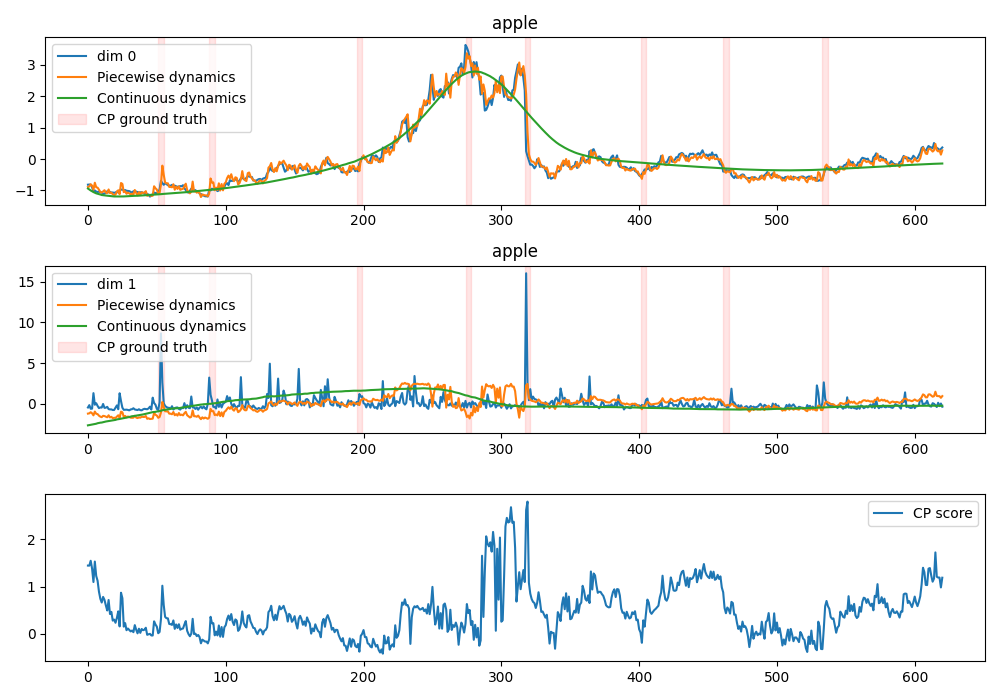

apple Best F1: 0.9157 Best Covering: 0.8487:  17%|█▋        | 1680/10000 [20:41:51<102:30:11, 44.35s/it]


KeyboardInterrupt: 

In [17]:
epochs = 10000
patience = 10000


best_f1, best_covering = 0, 0
no_progress = 0
t = tqdm(range(epochs), desc=f'{dataset_name}', leave=True)
fig = plt.figure(figsize=(10,7))
plt.ion()

fig.show()
fig.canvas.draw()

from numba import njit, jit
@jit
def tire_preprocessing(ts):
    res = []
    for i, v in enumerate(ts):
        left_ts = np.arange(i)[ts[:i]>v]
        if left_ts.shape[0]:
            left_ts = max(left_ts)
        else:
            left_ts = 0
        right_ts = np.arange(i+1,ts.shape[0])[ts[i+1:]>v]
        if right_ts.shape[0]:
            right_ts = min(right_ts)
        else:
            right_ts = ts.shape[0]-1
        a = ts[left_ts+1:i]
        b = ts[i+1:right_ts]
        if len(a) == 0: a = [0]
        if len(b) == 0: b = [0]
        v_ = v - max(min(a), min(b))
        res.append(v_)
    return np.array(res)


def get_indices(preds, agg_fn=lambda x: np.abs(x).max(1), margin=5, starting_points_to_ignore=2):        
    preds = agg_fn(preds)
    preds[0] = 0
    if margin == 'tire':
        preds = tire_preprocessing(preds)
    cpd_score = -preds
    change_points = np.argsort(cpd_score) + 1
    change_points = change_points[change_points > starting_points_to_ignore]
    res = []
    for point in change_points:
        if isinstance(margin, int) and any([abs(p1 - point) <= margin for p1 in res]):
            continue
        res.append(point)
    return res

    
for epoch in t:
    for i, (t0, X0, t1, X1) in enumerate(dataloader):
        no_jump_model.zero_grad(), jump_model.zero_grad()
        
        t0, X0, t1, X1 = [x.float().to(device)
                          for x in [t0, X0, t1, X1]]
        mu, sigma = X0.mean(0), X0.std(0)
        X0, X1 = [(x-mu)/sigma for x in [X0, X1]]
        batch_size = X0.shape[0] + 1
        X1_pred_no_jump = torchsde.sdeint(no_jump_model, X0[:1,:], torch.linspace(0,1,batch_size))[1:,0,:]
        loss_no_jump = F.mse_loss(X1_pred_no_jump, X1, reduce=False)
        loss_no_jump.mean().backward()
        no_jump_opt.step()
        X1_pred_jump = torchsde.sdeint(jump_model, X0, torch.linspace(0,1,2))[1,:,:]
        loss_jump = F.mse_loss(X1_pred_jump, X1, reduce=False)
        loss_jump.mean().backward()
        jump_opt.step()
#         print(jump_model.mu[0].weight.grad.mean())
#         print(loss_jump.mean())
    preds_jump = (X1_pred_jump - X1_pred_jump.mean(0))/X1_pred_jump.std(0)
    preds_no_jump = (X1_pred_no_jump - X1_pred_no_jump.mean(0))/X1_pred_no_jump.std(0)
    mse_jump = F.mse_loss(preds_jump, X1, reduce=False).detach().cpu().numpy()
    mse_no_jump = F.mse_loss(preds_no_jump, X1, reduce=False).detach().cpu().numpy()
    preds = (preds_jump/preds_jump.std(0)) - (preds_no_jump/preds_no_jump.std(0))
    preds = preds.detach().cpu().numpy()
    
    cp_indices_all = [
        get_indices(preds, lambda x: np.abs(x).max(1)), 
        get_indices(preds, lambda x: np.abs(x).mean(1)),
        get_indices(preds, lambda x: np.abs(x).min(1)),
        get_indices(preds, lambda x: np.abs(x).max(1), margin='tire'), 
        get_indices(preds, lambda x: np.abs(x).mean(1), margin='tire'),
        get_indices(preds, lambda x: np.abs(x).min(1), margin='tire'),
    ]
    
    f1 = max([f_measure(dataset.gt, cp_indices[:i]) for cp_indices in cp_indices_all
               for i in range(len(cp_indices) + 1)
             ])
    cov = max([covering(dataset.gt, cp_indices[:i], len(dataset)) 
               for cp_indices in cp_indices_all
               for i in range(len(cp_indices) + 1)])
    if f1 > best_f1:
#         print('Best F1 updated: %.4f -> %.4f' % (best_f1, f1))
        best_f1 = f1
        no_progress = 0
    if cov > best_covering:
#         print('Best covering updated: %.4f -> %.4f' % (best_covering, cov))
        best_covering = cov
        no_progress = 0
    if not any([f1 > best_f1, cov > best_covering]):
        no_progress += 1
    if no_progress > patience:
        break
    
    t.set_description('%s Best F1: %.4f Best Covering: %.4f' %
                      (dataset_name, best_f1, best_covering))
    t.refresh()
    vis_preds(fig, X1.detach().cpu().numpy(), dataset.gt, dataset_name, 
              preds_jump.detach().cpu().numpy(),
              preds_no_jump.detach().cpu().numpy(), 
              preds.max(1))

In [ ]:
0.6658, 0.9322 # Best Cov and F1 for SOTA